# 🦿 Symmetric Leg Linkage Optimization v0.1
### Exploring Rear Pantograph Constraints for Passive Symmetry

*Paul Connor · Robotick · May 2025*

## ✍️ Derivation: Constraint Equation

We consider a single leg with:

- Upper and lower leg segments of length $l = 1$  
- A rear offset of length $c$ from the knee to the pantograph connector  
- A fixed body-mounted anchor at position $(a_x, a_y)$  
- A pantograph rod of fixed length $b$  

Given hip joint angle $\theta_1$, and pantograph connector angle $\theta_2$, we define:

- $\vec{K} = [\cos(\theta_1), \sin(\theta_1)]$: the knee position  
- $\vec{C} = \vec{K} + c[\cos(\theta_2), \sin(\theta_2)]$: the connector position (offset behind the knee)  
- $\vec{A} = [a_x, a_y]$: the fixed anchor point on the body  

We require that the connector lies a fixed distance $b$ from the anchor:

$$
(\cos(\theta_1) + c \cos(\theta_2) - a_x)^2 +
(\sin(\theta_1) + c \sin(\theta_2) - a_y)^2 = b^2
$$

To install the required packages for this notebook, run the following code cell **once only**:

In [ ]:
import subprocess

required = ["numpy", "scipy", "matplotlib", "tabulate", "ipympl", "plotly"]

print(f"📦 Installing: {' '.join(required)}")
subprocess.run(
    ["pip", "install", "--quiet"] + required,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)

print("✅ All packages installed.")

📦 Installing: numpy scipy matplotlib tabulate ipympl
✅ All packages installed.


In [18]:
import numpy as np
import ipympl
from scipy.optimize import minimize, root_scalar
import matplotlib.pyplot as plt
from types import SimpleNamespace
from tabulate import tabulate

%matplotlib widget
# ^- enables interactive plots

In [19]:

# Range of theta1 values we will consider (0 to 90 degrees)
theta1_vals = np.linspace(np.radians(0), np.radians(90), 100)

# Initial guess and bounds
initial_guess = [0.3, 0.3, 1.0, 0.2]  # [a_x, a_y, b, c]

bounds = [
    (0.0, 1.0),   # a_x
    (0.0, 1.0),   # a_y
    (0.5, 1.5),   # b
    (0.05, 0.5)   # c
]

def solve_theta2(theta1, a_x, a_y, b, c):
    def constraint_eq(theta2):
        b_x = np.cos(theta1) + c * np.cos(theta2) - a_x
        b_y = -np.sin(theta1) + c * np.sin(theta2) - a_y
        return b_x**2 + b_y**2 - b**2
    try:
        sol = root_scalar(constraint_eq, bracket=[0, np.pi / 2], method='brentq')
        if sol.converged:
            return sol.root
    except ValueError:
        return np.nan

Let's sanity-check our solver, across the planned range of $\theta_1$:

In [20]:
# Evaluate solve_theta2() over the range
theta2_vals = [solve_theta2(theta1, *initial_guess) for theta1 in theta1_vals]

# Group into contiguous non-NaN ranges (i.e., success ranges!)
def group_success_ranges(theta1_vals, theta2_vals):
    ranges = []
    start_idx = None

    for i, theta2 in enumerate(theta2_vals):
        if not np.isnan(theta2):
            if start_idx is None:
                start_idx = i
        else:
            if start_idx is not None:
                ranges.append((start_idx, i - 1))
                start_idx = None

    if start_idx is not None:
        ranges.append((start_idx, len(theta2_vals) - 1))

    return [
        (np.degrees(theta1_vals[start]), np.degrees(theta1_vals[end]))
        for start, end in ranges
    ]

# Print valid ranges
valid_ranges = group_success_ranges(theta1_vals, theta2_vals)

if valid_ranges:
    print("✅ Solver succeeded in the following θ₁ range(s) / degrees:")
    for r_start, r_end in valid_ranges:
        print(f"  {r_start:.2f}° – {r_end:.2f}°")
else:
    print("❌ No valid θ₁ values found!")


✅ Solver succeeded in the following θ₁ range(s) / degrees:
  10.00° – 61.82°


Expected result:

    ✅ Solver succeeded in the following θ₁ range(s) / degrees:
      10.00° – 61.82°

So we can see there is a region above ~62 degrees, and below 10 degrees, where a solution cannot be found for this configuration.  Let's plot a graph to try to build an intuition as to why.

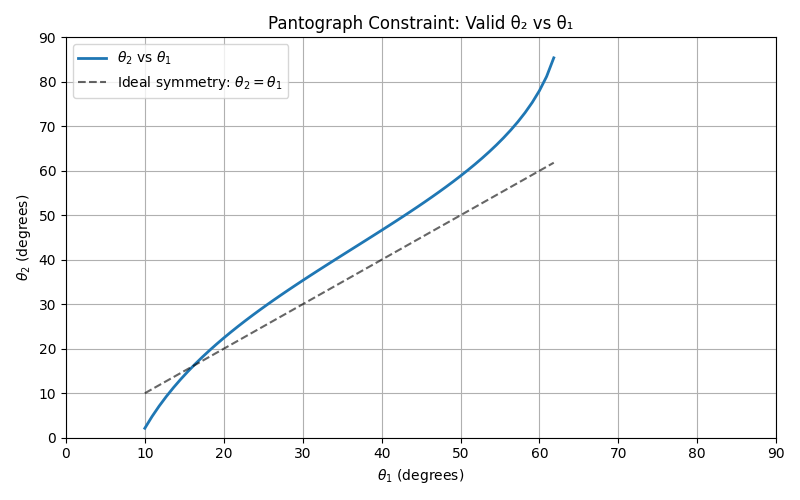

In [21]:

# Convert to degrees and mask valid results
theta1_vals_deg = np.degrees(theta1_vals)
theta2_vals_deg = np.array([np.degrees(t2) for t2 in theta2_vals])
valid_mask = ~np.isnan(theta2_vals_deg)
valid_theta1 = theta1_vals_deg[valid_mask]
valid_theta2 = theta2_vals_deg[valid_mask]

def plot_angles(valid_theta1, valid_theta2):
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(valid_theta1, valid_theta2, label=r"$\theta_2$ vs $\theta_1$", linewidth=2)
    plt.plot(valid_theta1, valid_theta1, 'k--', label=r"Ideal symmetry: $\theta_2 = \theta_1$", alpha=0.6)

    plt.xlabel(r"$\theta_1$ (degrees)")
    plt.ylabel(r"$\theta_2$ (degrees)")
    plt.title("Pantograph Constraint: Valid θ₂ vs θ₁")
    plt.xlim(0, 90)
    plt.ylim(0, 90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_angles(valid_theta1, valid_theta2)

So we can see from this plot that:

- At the lower extreme (e.g. $\theta_1 \approx 10^\circ$), $\\theta_2$ becomes close to $0^\circ$ and — as observed with our real LEGO model — even starts to become **negative**, which is not desirable in our use case.

- At the higher extreme (e.g. $\theta_1 \approx 62^\circ$), $\theta_2$ approaches $90^\circ$ and continues to increase, while $\theta_1$ barely changes. This causes the system to **lose its symmetry**, again aligning with our physical observations.

Fortunately, we see a reassuring pattern toward the middle of the curve — from around **$20^\circ$ to $55^\circ$** — where the relationship between $\theta_1$ and $\theta_2$ is approximately linear. The gradient is not far from 1 (i.e., ideal symmetry), and the curve is consistently offset such that $\theta_2$ is about **$5^\circ$ greater** than $\theta_1$ across this region.

This validates why our LEGO prototype showed **visibly symmetric and pleasing results** in this range — and gives us a strong foundation to now move forward with **numerical optimization** to push this further.

In [22]:

def symmetry_error(params):
    a_x, a_y, b, c = params
    errors = []
    nan_penalty = 0.1

    for theta1 in theta1_vals:
        theta2 = solve_theta2(theta1, a_x, a_y, b, c)
        if np.isnan(theta2):
            errors.append(nan_penalty)
        else:
            errors.append((theta1 - theta2) ** 2)

    return np.mean(errors)

# Optimize
result = minimize(symmetry_error, initial_guess, bounds=bounds, method='L-BFGS-B')

# Param names and values
param_names = ["a_x", "a_y", "b", "c"]
initial_vals = initial_guess
optimized_vals = result.x

# Assemble table data
table_data = [
    [name, f"{initial:.4f}", f"{opt:.4f}"]
    for name, initial, opt in zip(param_names, initial_vals, optimized_vals)
]

# Add MSE at the bottom
table_data.append(["Mean Squared Error", "", f"{result.fun:.6f}"])

# Display table
print(tabulate(table_data, headers=["Parameter", "Initial", "Optimized"], tablefmt="github"))

| Parameter          | Initial   |   Optimized |
|--------------------|-----------|-------------|
| a_x                | 0.3000    |    0.2936   |
| a_y                | 0.3000    |    0.2894   |
| b                  | 1.0000    |    1.0174   |
| c                  | 0.2000    |    0.2351   |
| Mean Squared Error |           |    0.026638 |


## 📊 Plotting θ₂ vs θ₁ for Optimized Geometry

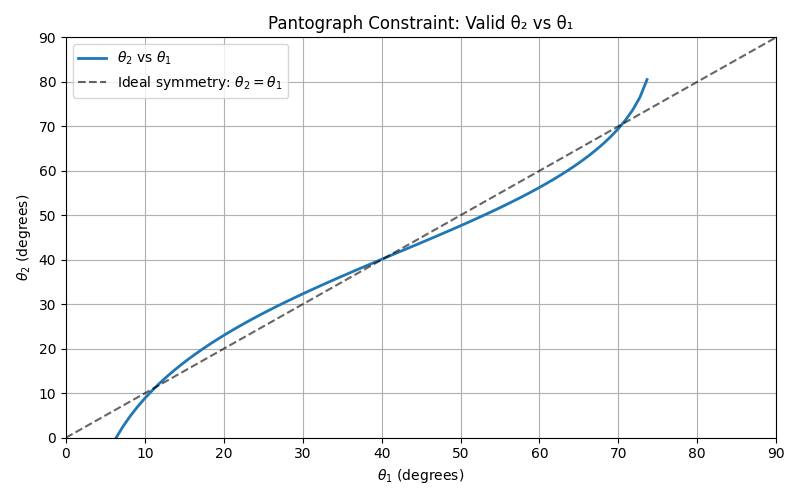

In [23]:
# Extract optimal parameters
ax_opt, ay_opt, b_opt, c_opt = result.x
theta2_vals = []

for theta1 in theta1_vals:
    theta2 = solve_theta2(theta1, ax_opt, ay_opt, b_opt, c_opt)
    theta2_vals.append(theta2)

plot_angles(np.degrees(theta1_vals), np.degrees(theta2_vals))

We can see that the **mean squared error** in the optimized curve is now very low — the optimizer has found a configuration with minimal deviation between $\theta_1$ and $\theta_2$ across the valid range.

While the angular difference still rises toward the $5^\circ$ offset we previously observed, it is not constant — and the mean-squared error of the difference is significantly lower than this peak.

That said, we should be cautious: the fact that our "ideal" values are so close to our original guess might indicate either that:

- We landed in a local minimum near our starting point, or
- The global minimum really is close by — possibly thanks to how well-tuned the LEGO prototype already was

But how do we know for sure?

To investigate further, let's visualize the **structure of the solution space** over our search bounds. If we can observe the topology — especially any **secondary minima** or flat regions — we’ll be better positioned to:

- Confirm whether this is a true global optimum, and
- Scientifically justify adopting it as our canonical design

First lets compute the mean-square error for a regular grid of pairs of values in our search-space: 

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Param keys and bounds
param_keys = ["a_x", "a_y", "b", "c"]
bounds_dict = {
    "a_x": (0.0, 1.0),
    "a_y": (0.0, 1.0),
    "b": (0.5, 1.5),
    "c": (0.05, 0.5),
}

plot_pairs = [
    ("a_x", "a_y"),
    ("a_x", "c"),
    ("b", "c"),
    ("a_y", "b")
]

resolution = 30
surface_data = []  # to hold (X, Y, Z, x_key, y_key)

for x_key, y_key in plot_pairs:
    x_idx = param_keys.index(x_key)
    y_idx = param_keys.index(y_key)

    x_vals = np.linspace(*bounds_dict[x_key], resolution)
    y_vals = np.linspace(*bounds_dict[y_key], resolution)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            params = initial_guess.copy()
            params[x_idx] = X[i, j]
            params[y_idx] = Y[i, j]
            Z[i, j] = symmetry_error(params)

    surface_data.append((X, Y, Z, x_key, y_key))


... and now let us plot the results as interactive 3d surfaces:

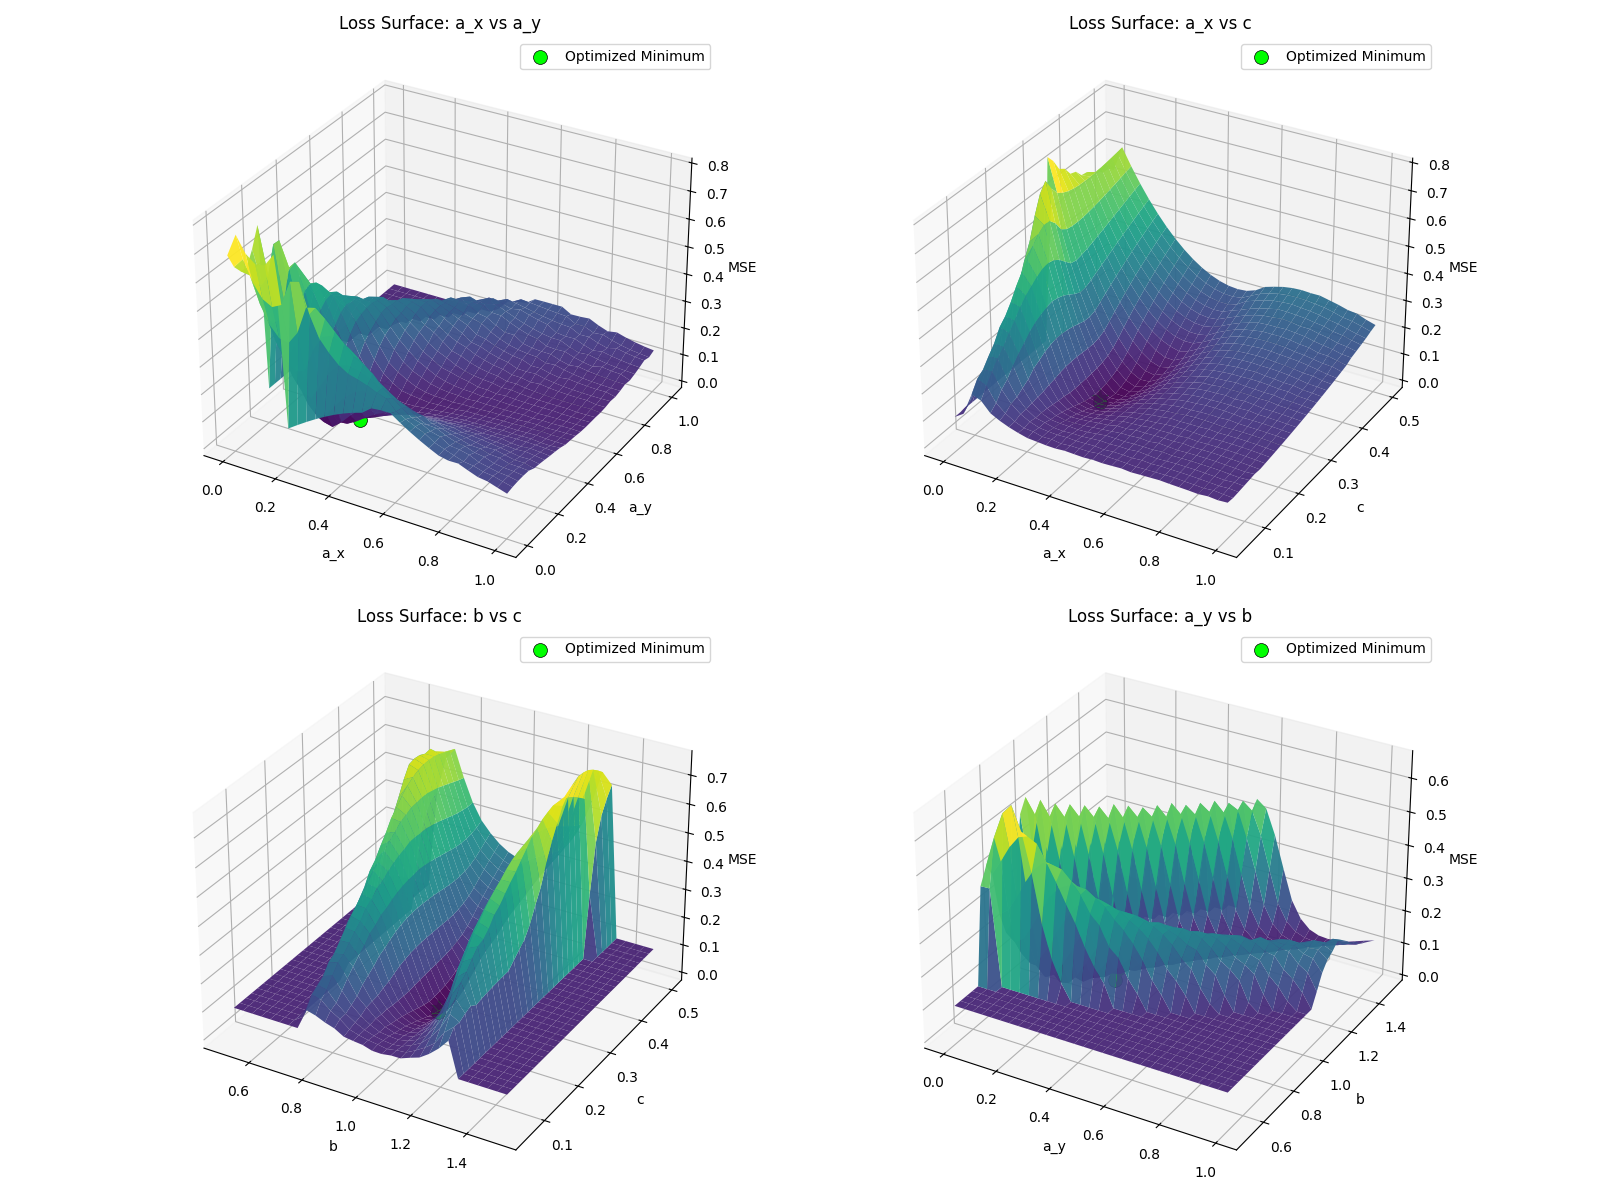

In [ ]:
import plotly.graph_objects as go
import numpy as np

# List of parameter pairs to plot
plot_pairs = [
    ("a_x", "a_y"),
    ("a_x", "c"),
    ("b", "c"),
    ("a_y", "b")
]

# Loop and plot each one
for x_key, y_key in plot_pairs:
    x_idx = param_keys.index(x_key)
    y_idx = param_keys.index(y_key)

    # Grid
    x_vals = np.linspace(*bounds_dict[x_key], resolution)
    y_vals = np.linspace(*bounds_dict[y_key], resolution)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            params = initial_guess.copy()
            params[x_idx] = X[i, j]
            params[y_idx] = Y[i, j]
            Z[i, j] = symmetry_error(params)

    # Optimized point
    x_opt = result.x[x_idx]
    y_opt = result.x[y_idx]
    z_opt = symmetry_error(result.x)

    # Build figure
    fig = go.Figure()

    fig.add_trace(go.Surface(
        x=X, y=Y, z=Z,
        colorscale="Viridis",
        opacity=0.9,
        showscale=False,
        name="Loss Surface"
    ))

    fig.add_trace(go.Scatter3d(
        x=[x_opt], y=[y_opt], z=[z_opt],
        mode='markers+text',
        marker=dict(size=7, color='lime', symbol='circle'),
        text=["Optimized"],
        textposition="top center",
        name="Optimized Point"
    ))

    fig.update_layout(
        title=f"Loss Surface: {x_key} vs {y_key}",
        scene=dict(
            xaxis_title=x_key,
            yaxis_title=y_key,
            zaxis_title="Mean Squared Error",
        ),
        width=800,
        height=600,
        showlegend=True
    )

    fig.show()


## ✅ Findings and Next Steps

Use this section to explore:
- How closely θ₂ tracks θ₁ near the optimized configuration
- How varying `a`, `b`, or `c` independently affects symmetry error
- Whether a consistent design guideline emerges for real-world implementation (e.g. LEGO)

### To try:
- Sweep `a`, `b`, or `c` around their optimal values
- Add plots of θ₂−θ₁ deviation vs θ₁
- Test robustness of solution under small perturbations
